# 0. Import Library

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from tensorflow.keras import layers, regularizers, Model

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

2025-05-19 02:56:45.919028: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747623406.112926      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747623406.168576      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. Business Understanding

# 2. Data Understanding

## 2.1 Load Data dan Cetak Atribut Tabel

In [2]:
dataUser = pd.read_csv("/kaggle/input/book-reccomendation-dataset/Data/Users.csv")
dataBuku = pd.read_csv("/kaggle/input/book-reccomendation-dataset/Data/Books.csv")
dataRating = pd.read_csv("/kaggle/input/book-reccomendation-dataset/Data/Ratings.csv")

dataUser.info()
dataBuku.info()
dataRating.info()

/tmp/ipykernel_19/3745290253.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  dataBuku = pd.read_csv("/kaggle/input/book-reccomendation-dataset/Data/Books.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)


## 2.2 Identifikasi Karakteristik Data dan Cetak Ringkasan Statistik

In [3]:
dataUser = dataUser.rename(columns={
    'User-ID': 'userID'
})
dataRating = dataRating.rename(columns={
    'User-ID': 'userID'
})

print('Banyak User : ', len(dataUser.userID.unique()))
print('Banyak Buku : ', len(dataBuku.ISBN.unique()))
print('Banyak User yang Memberi Rating : ', len(dataRating.userID.unique()))

Banyak User :  278858
Banyak Buku :  271360
Banyak User yang Memberi Rating :  105283


## 2.3 Identifikasi Ringkasan Statistik Data

### 2.3.1 Ringkasan Statistik Dataset Books

In [4]:
dataBuku.drop(columns=['Image-URL-S','Image-URL-M','Image-URL-L','ISBN']).describe(include='all')

,Book-Title,Book-Author,Year-Of-Publication,Publisher
count,271360,271358,271360,271358
unique,242135,102022,202,16807
top,Selected Poems,Agatha Christie,2002,Harlequin
freq,27,632,13903,7535


### 2.3.2 Ringkasan Statistik Dataset Ratings

In [5]:
dataRating.drop(columns=['userID']).describe(include='all')

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,ISBN,Book-Rating
count,1149780,1.149780e+06
unique,340556,NaN
top,0971880107,NaN
freq,2502,NaN
mean,NaN,2.866950e+00
std,NaN,3.854184e+00
min,NaN,0.000000e+00
25%,NaN,0.000000e+00
50%,NaN,0.000000e+00
75%,NaN,7.000000e+00


### 2.3.3 Ringkasan Statistik Dataset Users

In [6]:
dataUser.drop(columns=['userID']).describe(include='all')

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Location,Age
count,278858,168096.000000
unique,57339,NaN
top,"london, england, united kingdom",NaN
freq,2506,NaN
mean,NaN,34.751434
std,NaN,14.428097
min,NaN,0.000000
25%,NaN,24.000000
50%,NaN,32.000000
75%,NaN,44.000000


## 2.4 Pengecekan Missing Value

In [7]:
dataUser.isnull().sum()

userID           0
Location         0
Age         110762
dtype: int64

In [8]:
dataBuku.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [9]:

dataRating.isnull().sum()

userID         0
ISBN           0
Book-Rating    0
dtype: int64

# 3. Data Preparation

## 3.1 Join Tabel

In [10]:
# Gabungkan Data Rating dengan Data User untuk memperoleh dataset rating beserta atribut usernya
dataRatingUser = pd.merge(dataRating, dataUser, on='userID', how='left')
# Gabungkan dataset sebelumnya dengan dataset buku untuk memperoleh keterangan buku yang diberi rating
dataset = pd.merge(dataRatingUser, dataBuku, on='ISBN', how='left')

In [11]:
dataset.info()
dataset.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   userID               1149780 non-null  int64  
 1   ISBN                 1149780 non-null  object 
 2   Book-Rating          1149780 non-null  int64  
 3   Location             1149780 non-null  object 
 4   Age                  840288 non-null   float64
 5   Book-Title           1031136 non-null  object 
 6   Book-Author          1031134 non-null  object 
 7   Year-Of-Publication  1031136 non-null  object 
 8   Publisher            1031134 non-null  object 
 9   Image-URL-S          1031136 non-null  object 
 10  Image-URL-M          1031136 non-null  object 
 11  Image-URL-L          1031132 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 105.3+ MB


userID                      0
ISBN                        0
Book-Rating                 0
Location                    0
Age                    309492
Book-Title             118644
Book-Author            118646
Year-Of-Publication    118644
Publisher              118646
Image-URL-S            118644
Image-URL-M            118644
Image-URL-L            118648
dtype: int64

## 3.2 Eliminasi Observasi dengan Missing Value

In [12]:
dataFinal = dataset.dropna()

### 3.3.1 Preprocessing untuk Content Based Filtering

In [13]:
# Membentuk Variabel Baru yang menangkap atribut dari Buku
dataFinal['AtributBuku'] = dataFinal['Book-Title'] + ' ' + dataFinal['Book-Author'] + ' ' + dataFinal['Year-Of-Publication'].astype(str)

# Preprocessing: Convert to lowercase, remove punctuation
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

dataFinal['AtributBuku'] = dataFinal['AtributBuku'].apply(preprocess_text)

# Undersampling untuk Reduksi Dataset
dataBaru = dataFinal.dropna(subset=['AtributBuku']).sample(n=90000, random_state=42).reset_index(drop=True)

/tmp/ipykernel_19/3961848135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFinal['AtributBuku'] = dataFinal['Book-Title'] + ' ' + dataFinal['Book-Author'] + ' ' + dataFinal['Year-Of-Publication'].astype(str)
/tmp/ipykernel_19/3961848135.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFinal['AtributBuku'] = dataFinal['AtributBuku'].apply(preprocess_text)


### 3.3.2 Preprocessing untuk Colaborative Filtering

In [14]:
# Mengubah userID menjadi list unik
user_ids = dataFinal['userID'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

# Mengubah ISBN menjadi list unik
buku_ids = dataFinal['ISBN'].unique().tolist()
buku_to_ids_encoded = {x: i for i, x in enumerate(buku_ids)}
ids_to_buku_encoded = {i: x for i, x in enumerate(buku_ids)}

# Melakukan encoding ke dataframe
dataFinal['user_encoded'] = dataFinal['userID'].map(user_to_user_encoded)
dataFinal['ISBN_encoded'] = dataFinal['ISBN'].map(buku_to_ids_encoded)

# Cek apakah ada yang gagal di-encode
if dataFinal[['user_encoded', 'ISBN_encoded']].isnull().values.any():
    print("🚨 Ada userID atau ISBN yang tidak berhasil di-encode!")
    print("Jumlah user_encoded NaN:", dataFinal['user_encoded'].isnull().sum())
    print("Jumlah ISBN_encoded NaN:", dataFinal['ISBN_encoded'].isnull().sum())
    # Bisa drop baris NaN atau isi dengan nilai default
    dataFinal = dataFinal.dropna(subset=['user_encoded', 'ISBN_encoded'])

# Convert ke integer untuk keperluan input model embedding
dataFinal['user_encoded'] = dataFinal['user_encoded'].astype(np.int32)
dataFinal['ISBN_encoded'] = dataFinal['ISBN_encoded'].astype(np.int32)

# Konversi rating ke float32
dataFinal['Book-Rating'] = dataFinal['Book-Rating'].astype(np.float32)

# Info statistik
num_users = len(user_to_user_encoded)
num_items = len(ids_to_buku_encoded)
min_rating = dataFinal['Book-Rating'].min()
max_rating = dataFinal['Book-Rating'].max()

print(f'Jumlah User: {num_users}, Jumlah Buku: {num_items}, Min Rating: {min_rating}, Max Rating: {max_rating}')

/tmp/ipykernel_19/3581592387.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFinal['user_encoded'] = dataFinal['userID'].map(user_to_user_encoded)


Jumlah User: 53887, Jumlah Buku: 228995, Min Rating: 0.0, Max Rating: 10.0


/tmp/ipykernel_19/3581592387.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFinal['ISBN_encoded'] = dataFinal['ISBN'].map(buku_to_ids_encoded)
/tmp/ipykernel_19/3581592387.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFinal['user_encoded'] = dataFinal['user_encoded'].astype(np.int32)
/tmp/ipykernel_19/3581592387.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [15]:
# Mengacak dataset
df = dataFinal.sample(frac=1, random_state=42)
df

# Membuat variabel x untuk mencocokkan data user dan resto menjadi satu value
x = df[['user_encoded', 'ISBN_encoded']].values
 
# Membuat variabel y untuk membuat rating dari hasil 
y = df['Book-Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

# 4. Modelling

## 4.1 Content Based Filtering

### 4.1.1 Membentuk Matriks Term Frequency - Inverse Document Frequency

In [16]:
# Buat dataframe baru berisi data unik dari AtributBuku
dataBaru = dataBaru.drop_duplicates(subset='AtributBuku').reset_index(drop=False)

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(dataBaru['AtributBuku'])

### 4.1.2 Membentuk Matriks Cosine Similarity

In [17]:
cosine_sim = cosine_similarity(tfidf_matrix, dense_output=False)


### 4.1.3 Pendefinisian Fungsi Rekomendasi Produk

In [18]:
def recommend(book_title, cosine_sim=cosine_sim, jmlbuku = 5):
    print(f"Menampilkan Rekomendasi Buku yang sesuai dengan '{book_title}' ...")
    
    matches = dataBaru[dataBaru['Book-Title'] == book_title]
    if matches.empty:
        return f"Tidak ditemukan judul: {book_title}"
    
    # matches.index sudah 0..n-1, cocok untuk cosine_sim
    idx = matches.index[0]

    sim_scores_row = cosine_sim[idx].toarray().flatten()

    sim_scores = list(enumerate(sim_scores_row))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:jmlbuku+1]  # skip buku itu sendiri

    book_indices = [i[0] for i in sim_scores]
    scores = [i[1] for i in sim_scores]

    result = dataBaru.iloc[book_indices][['Book-Title', 'Book-Author', 'Publisher', 'Year-Of-Publication']].copy()
    result['similarity_score'] = scores

    return result.reset_index(drop=True)


In [19]:
recommend(dataBaru['Book-Title'].dropna().sample(1).iloc[0])


Menampilkan Rekomendasi Buku yang sesuai dengan 'Overeaters Anonymous' ...


,Book-Title,Book-Author,Publisher,Year-Of-Publication,similarity_score
0,The Twelve Steps and Twelve Traditions of Over...,Overeaters Anonymous Incorporated Staff,Overeaters Anonymous,1993,0.822650
1,"Annie's Baby: The Diary of Anonymous, a Pregna...",Anonymous,Avon,1998,0.410268
2,Go Ask Alice,Anonymous,Simon Pulse,1998,0.377200
3,The Ithon,Anonymous,Infinity Publishing (PA),2003,0.365937
4,Go Ask Alice,Anonymous,Simon &amp; Schuster Children's Publishing,1971,0.342711


## 4.2 Collaborative Filtering

### 4.2.1 Pendefinisian Model RecommenderNet (Neural Colaborative Filtering)

In [ ]:
class RecommenderNet(Model):

    def __init__(self, num_users, num_buku, embedding_size, dropout_rate=0.3, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_buku = num_buku
        self.embedding_size = embedding_size
        self.dropout_rate = dropout_rate

        # User Embedding Layer
        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(input_dim=num_users, output_dim=1)

        # Item Embedding Layer
        self.buku_embedding = layers.Embedding(
            input_dim=num_buku,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )
        self.buku_bias = layers.Embedding(input_dim=num_buku, output_dim=1)

        # Dropout Layer
        self.dropout = layers.Dropout(dropout_rate)

        # Fully Connected Layer
        self.fc1 = layers.Dense(embedding_size, activation='relu')
        self.batch_norm = layers.BatchNormalization()
        self.fc2 = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        # Extract user and item embeddings
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        buku_vector = self.buku_embedding(inputs[:, 1])
        buku_bias = self.buku_bias(inputs[:, 1])

        # Normalize embeddings
        user_vector = tf.nn.l2_normalize(user_vector, axis=1)
        buku_vector = tf.nn.l2_normalize(buku_vector, axis=1)

        # Compute dot product
        dot_product = tf.reduce_sum(user_vector * buku_vector, axis=1, keepdims=True)

        # Add biases
        x = dot_product + user_bias + buku_bias

        # Apply dropout and dense layers
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.batch_norm(x)
        x = self.fc2(x)

        return x

In [21]:
model = RecommenderNet(num_users, num_items, 1024) # inisialisasi model
 
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=8e-5),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

I0000 00:00:1747623434.677920      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


### 4.2.2 Pelatihan Model Rekomendasi

In [22]:
# Memulai training
 
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 1024,
    epochs = 10,
    validation_data = (x_val, y_val)
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 234490880 elements. This may consume a large amount of memory.
  warnings.warn(
I0000 00:00:1747623440.142668      59 service.cc:148] XLA service 0x7970f400b9b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747623440.143260      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747623440.423656      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/589 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - loss: 0.2034 - rmse: 0.4464  

I0000 00:00:1747623441.466627      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - loss: 0.1678 - rmse: 0.4048 - val_loss: 0.1460 - val_rmse: 0.3781
Epoch 2/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 0.0525 - rmse: 0.2214 - val_loss: 0.1361 - val_rmse: 0.3648
Epoch 3/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - loss: 0.0179 - rmse: 0.1221 - val_loss: 0.1365 - val_rmse: 0.3655
Epoch 4/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 0.0151 - rmse: 0.1107 - val_loss: 0.1382 - val_rmse: 0.3680
Epoch 5/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 0.0133 - rmse: 0.1028 - val_loss: 0.1399 - val_rmse: 0.3705
Epoch 6/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 0.0114 - rmse: 0.0940 - val_loss: 0.1443 - val_rmse: 0.3766
Epoch 7/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 0.0107 - rmse: 0.0907 - val_loss: 0.1508 - val_rmse: 0.3852
Epoch 8/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 0.0099 - rmse: 0.0866 - val_loss: 0.1572 - val_rmse: 0.3936
Epoch 9/10
589/589 ━━━━━━━━━━━━━━━━

### 4.2.3 Visualisasi Hasil Pelatihan

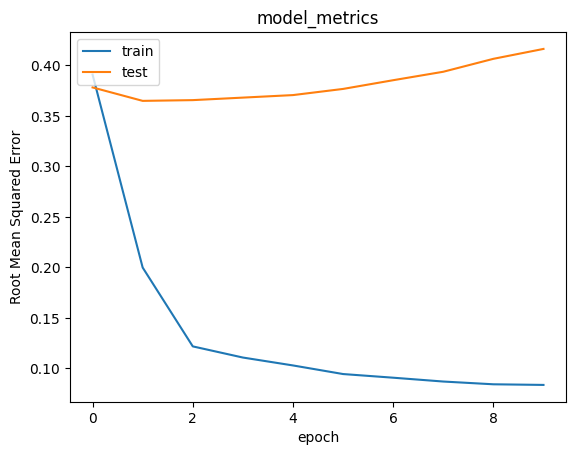

In [23]:
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model_metrics')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 4.2.4 Merekomendasikan Buku

In [24]:
def recommend_books_for_user(model, user_id_asli, data, buku_df, user_to_user_encoded, buku_to_ids_encoded, ids_to_buku_encoded, top_n=10):
    # Cek apakah user_id valid
    if user_id_asli not in user_to_user_encoded:
        print("User ID tidak ditemukan.")
        return []

    user_encoded = user_to_user_encoded[user_id_asli]
    buku_user_sudah_rating = data[data['userID'] == user_id_asli]['ISBN'].tolist()
    buku_user_sudah_encoded = [buku_to_ids_encoded[buku] for buku in buku_user_sudah_rating]

    # Semua buku yang belum diberi rating oleh user
    buku_tidak_dirating = list(set(buku_to_ids_encoded.values()) - set(buku_user_sudah_encoded))
    user_encoded_array = np.full(len(buku_tidak_dirating), user_encoded)
    
    # Membuat data pasangan user-buku
    input_pairs = np.array(list(zip(user_encoded_array, buku_tidak_dirating)))

    # Prediksi skor
    ratings = model.predict(input_pairs).flatten()
    
    # Ambil top-N
    top_indices = ratings.argsort()[-top_n:][::-1]
    top_buku_encoded = [buku_tidak_dirating[i] for i in top_indices]
    top_buku_isbn = [ids_to_buku_encoded[i] for i in top_buku_encoded]

    # Gabungkan dengan info buku (jika ada dataframe buku_df)
    rekomendasi = buku_df[buku_df['ISBN'].isin(top_buku_isbn)].copy() if buku_df is not None else pd.DataFrame({'ISBN': top_buku_isbn})
    rekomendasi['Predicted_Score'] = ratings[top_indices]
    
    return rekomendasi.sort_values(by='Predicted_Score', ascending=False)

# Menampilkan 5 userID unik pertama dari data
sample_user_ids = dataFinal['userID'].unique()[:5]
user_id_sample = sample_user_ids[0]  # atau pilih indeks lain

# Contoh penggunaan:
rekomendasi_df = recommend_books_for_user(model, user_id_asli=user_id_sample, data=dataFinal, buku_df=dataBuku,
    user_to_user_encoded=user_to_user_encoded,
    buku_to_ids_encoded=buku_to_ids_encoded,
    ids_to_buku_encoded=ids_to_buku_encoded,
    top_n=5)

# Tampilkan hasil
display(rekomendasi_df)


7157/7157 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Predicted_Score
49874,0943221250,Acts of Faith,Jane Mead,1995,Timken Publishers,http://images.amazon.com/images/P/0943221250.0...,http://images.amazon.com/images/P/0943221250.0...,http://images.amazon.com/images/P/0943221250.0...,0.752928
49927,0380008408,Formula Book,Norman Stark,1976,Harper Mass Market Paperbacks (Mm),http://images.amazon.com/images/P/0380008408.0...,http://images.amazon.com/images/P/0380008408.0...,http://images.amazon.com/images/P/0380008408.0...,0.748365
49952,0373790643,"Hands On: Trueblood Texas (Harlequin Blaze, No...",Debbi Rawlins,2002,Harlequin,http://images.amazon.com/images/P/0373790643.0...,http://images.amazon.com/images/P/0373790643.0...,http://images.amazon.com/images/P/0373790643.0...,0.748361
69111,1889392081,Bridal Bargains: Secrets to Throwing a Fantast...,Denise Fields,2000,Windsor Peak Press,http://images.amazon.com/images/P/1889392081.0...,http://images.amazon.com/images/P/1889392081.0...,http://images.amazon.com/images/P/1889392081.0...,0.747718
127763,0345446992,Black Valley,Jim Brown,2003,Ballantine Books,http://images.amazon.com/images/P/0345446992.0...,http://images.amazon.com/images/P/0345446992.0...,http://images.amazon.com/images/P/0345446992.0...,0.746603


# 5. Evaluasi

## 5.1 Evaluasi Content Based Filtering : Cosine Similarity

In [25]:
def evaluate_cbf_recommender(dataBaru, recommend_fn, users_to_evaluate, k=5):
    results = []
    user_books = dataBaru.groupby("userID")["Book-Title"].apply(set).to_dict()

    for user in users_to_evaluate:
        books_read = list(user_books.get(user, []))
        if not books_read:
            continue
        seed_book = pd.Series(books_read).dropna().sample(1).iloc[0]
        try:
            rec_df = recommend_fn(seed_book, cosine_sim, len(books_read))
        except:
            continue
        rec_books = rec_df["Book-Title"].tolist()[:k]
        actual_books = set(books_read)
        relevance_vector = [1 if book in actual_books else 0 for book in rec_books]
        true_positives = sum(relevance_vector)

        precision = true_positives / k if k > 0 else 0
        recall = true_positives / len(actual_books) if actual_books else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        hit_rate = 1 if true_positives > 0 else 0

        results.append({
            "userID": user,
            "seed_book": seed_book,
            "recommended": rec_books,
            "actual": list(actual_books),
            "relevance_vector": relevance_vector,
            "precision@k": precision,
            "recall@k": recall,
            "f1_score@k": f1_score,
            "hit_rate@k": hit_rate
        })

    results_df = pd.DataFrame(results)
    avg_precision = results_df["precision@k"].mean()
    avg_recall = results_df["recall@k"].mean()
    avg_f1 = results_df["f1_score@k"].mean()
    avg_hit_rate = results_df["hit_rate@k"].mean()

    return results_df, avg_precision, avg_recall, avg_f1, avg_hit_rate

import random

# Hitung jumlah buku per user
user_book_counts = dataBaru.groupby("userID")["Book-Title"].nunique()

# Filter user dengan minimal 5 buku
eligible_users = user_book_counts[user_book_counts >= 5].index.tolist()

# Ambil sample user dari yang eligible
sample_users = random.sample(eligible_users, 10)

# Jalankan evaluasi
results_df, avg_prec, avg_rec, avg_f1, avg_hr = evaluate_cbf_recommender(dataBaru, recommend, sample_users, k=5)

print(f"Avg Precision@5: {avg_prec:.4f}")
print(f"Avg Recall@5: {avg_rec:.4f}")
print(f"Avg F1-Score@5: {avg_f1:.4f}")
print(f"Avg Hit Rate@5: {avg_hr:.4f}")

results_df.head()


Menampilkan Rekomendasi Buku yang sesuai dengan 'Hokkaido Highway Blues: Hitchhiking Japan' ...
Menampilkan Rekomendasi Buku yang sesuai dengan 'The Black Prince' ...
Menampilkan Rekomendasi Buku yang sesuai dengan 'A Walk to Remember' ...
Menampilkan Rekomendasi Buku yang sesuai dengan 'Ceremony of the Innocent' ...
Menampilkan Rekomendasi Buku yang sesuai dengan 'Magic Knight Rayearth #4' ...
Menampilkan Rekomendasi Buku yang sesuai dengan 'Men in Blue (Badge of Honor Novels (Paperback))' ...
Menampilkan Rekomendasi Buku yang sesuai dengan 'Teach Yourself Unix in a Week' ...
Menampilkan Rekomendasi Buku yang sesuai dengan 'Lucy Sullivan Is Getting Married' ...
Menampilkan Rekomendasi Buku yang sesuai dengan 'All the Pretty Horses (The Border Trilogy, Vol 1)' ...
Menampilkan Rekomendasi Buku yang sesuai dengan 'Adobe Photoshop 3: Filters and Effects' ...
Avg Precision@5: 0.1000
Avg Recall@5: 0.0321
Avg F1-Score@5: 0.0468
Avg Hit Rate@5: 0.4000


,userID,seed_book,recommended,actual,relevance_vector,precision@k,recall@k,f1_score@k,hit_rate@k
0,58062,Hokkaido Highway Blues: Hitchhiking Japan,[How to Be a Canadian: Even If You Already are...,"[Hokkaido Highway Blues: Hitchhiking Japan, AR...","[0, 0, 0, 0, 0]",0.0,0.000000,0.000000,0
1,42093,The Black Prince,"[Something Special: A Story, The Unicorn, The ...",[The Runelords: The Sum of All Men (The Runelo...,"[0, 0, 0, 0, 0]",0.0,0.000000,0.000000,0
2,249628,A Walk to Remember,"[A Walk to Remember, The Rescue, The Wedding, ...","[Acts of Love, Little Hobo, Gabriel's lady, Ha...","[1, 0, 0, 0, 0]",0.2,0.038462,0.064516,1
3,161752,Ceremony of the Innocent,"[Ceremony of the Innocent, Caldwell, Answer As...","[Jellyfish Season, River's End, The A-Z Guide ...","[1, 0, 0, 0, 0]",0.2,0.052632,0.083333,1
4,156111,Magic Knight Rayearth #4,"[Magic Knight Rayearth #5, Magic Knight Rayear...","[Priestess (Fushigi Yugi: The Mysterious Play,...","[1, 0, 0, 0, 0]",0.2,0.125000,0.153846,1


## 5.2 Evaluasi Colaborative Filtering

In [26]:
from sklearn.metrics import mean_squared_error
import numpy as np

def evaluate_cf_model(
    model, 
    x_val, 
    y_val, 
    dataFinal, 
    buku_df,
    user_to_user_encoded, 
    buku_to_ids_encoded, 
    ids_to_buku_encoded, 
    k=5
):
    # Buat DataFrame val dari x_val dan y_val
    val_df = pd.DataFrame({
        "user_encoded": x_val[:, 0],
        "buku_encoded": x_val[:, 1],
        "interaction": y_val
    })

    # Filter interaksi positif
    val_pos_df = val_df[val_df["interaction"] > 0]

    # Mapping user_encoded -> set buku_encoded
    user_items_val = val_pos_df.groupby("user_encoded")["buku_encoded"].apply(set).to_dict()

    # Ambil 10 user secara acak
    users_to_eval = list(user_items_val.keys())
    if len(users_to_eval) > 10:
        users_to_eval = random.sample(users_to_eval, 10)

    results = []

    for user_encoded in users_to_eval:
        user_id_asli = next((k_ for k_, v_ in user_to_user_encoded.items() if v_ == user_encoded), None)
        if user_id_asli is None:
            continue

        actual_items = user_items_val[user_encoded]

        rekomendasi_df = recommend_books_for_user(
            model=model,
            user_id_asli=user_id_asli,
            data=dataFinal,
            buku_df=buku_df,
            user_to_user_encoded=user_to_user_encoded,
            buku_to_ids_encoded=buku_to_ids_encoded,
            ids_to_buku_encoded=ids_to_buku_encoded,
            top_n=k
        )

        rec_books_encoded = [
            buku_to_ids_encoded[isbn] for isbn in rekomendasi_df['ISBN'] if isbn in buku_to_ids_encoded
        ] if not rekomendasi_df.empty else []

        relevance_vector = [1 if book in actual_items else 0 for book in rec_books_encoded]
        true_positives = sum(relevance_vector)

        precision = true_positives / k if k > 0 else 0
        recall = true_positives / len(actual_items) if actual_items else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        hit_rate = 1 if true_positives > 0 else 0

        results.append({
            "user_encoded": user_encoded,
            "user_id_asli": user_id_asli,
            "recommended_encoded": rec_books_encoded,
            "actual_encoded": list(actual_items),
            "relevance_vector": relevance_vector,
            "precision@k": precision,
            "recall@k": recall,
            "f1_score@k": f1_score,
            "hit_rate@k": hit_rate
        })

    results_df = pd.DataFrame(results)
    avg_precision = results_df["precision@k"].mean()
    avg_recall = results_df["recall@k"].mean()
    avg_f1 = results_df["f1_score@k"].mean()
    avg_hit_rate = results_df["hit_rate@k"].mean()

    # Hitung RMSE pada seluruh validation set
    y_pred = model.predict(x_val).flatten()
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return results_df, avg_precision, avg_recall, avg_f1, avg_hit_rate, rmse

In [27]:
results_df, avg_prec, avg_rec, avg_f1, avg_hr, rmse = evaluate_cf_model(
    model, x_val, y_val, dataFinal, dataBuku,
    user_to_user_encoded, buku_to_ids_encoded, ids_to_buku_encoded,
    k=5
)

print(f"Avg Precision@5: {avg_prec:.4f}")
print(f"Avg Recall@5: {avg_rec:.4f}")
print(f"Avg F1-Score@5: {avg_f1:.4f}")
print(f"Avg Hit Rate@5: {avg_hr:.4f}")
print(f"RMSE: {rmse:.4f}")


7157/7157 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7156/7156 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
7157/7157 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7156/7156 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7156/7156 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7157/7157 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7156/7156 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7154/7154 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
7156/7156 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7154/7154 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Avg Precision@5: 0.0000
Avg Recall@5: 0.0000
Avg F1-Score@5: 0.0000
Avg Hit Rate@5: 0.0000
RMSE: 0.4162
